<a href="https://colab.research.google.com/github/howakuro/Bandit/blob/master/Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#各種インポート

**実行するに当たって用意すべき環境**<br>
Python3<br>
matplotlib<br>
numpy<br>
</p>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

#n本腕バンディット問題
n個のスロットがあると仮定する。<br>
各スロットに設定された当たり確率は不明だが、当たった時に報酬が１、当たらなかった時に報酬が0であるということだけが分かっている。<br>
この当たり確率が不明な状況下で最も当たり確率が高いスロットをなるべく早く見つけ出すことを目的とする強化学習の最も基本的な問題である。

In [0]:
#n本腕バンディット問題の環境
class Bandit(object):
    def __init__(self,arm_num = 2):
        print("【設定確率】")
        self._set_arm_probability(arm_num)
        print(self._arm_probability)
    
    #ランダムに各アームを初期化する際にmainで事前に呼び出す
    @classmethod
    def get_probability(self,arm_num):
        idx = np.random.choice(range(arm_num))
        return [0.6 if i == idx else 0.4 for i in range(arm_num)]
    
    def _set_arm_probability(self,arm_num):#定数初期化 定数で初期化する場合はnew_probabilityを定数に書き換える
        self._arm_probability = newprobability#[0.4, 0.3]

    #選んだアームのスロットを回す
    def play_arm(self,select_arm):
        if random.random() <= self._arm_probability[select_arm]:
            return 1.0
        else:
            return 0.0

#価値関数
各行動と状態における長期的な価値を推定する関数。今回は1回腕を回したときの各腕の期待値を求める。

##テーブル形式QLearning

In [0]:
class Q_Learning(object):
    def __init__(self,arm_num = 2,alpha = 0.1,gamma = 0.9):
        self.arm_num = arm_num
        self.alpha = alpha
        self.gamma = gamma
        self.reset()
    
    #リセット
    def reset(self):
        self._init_qtable()
    
    #Qテーブル取得
    def get_value(self):
        return self._qtable

    #Qテーブル初期化
    def _init_qtable(self):
        self._qtable = [0 for i in range(self.arm_num)]
    
    #Qテーブル更新
    def update(self,action,reward):
        td_error = reward - self._qtable[action]
        self._qtable[action] += self.alpha * td_error

##RS関数

In [0]:
#RS関数
class RS(object):
    def __init__(self,arm_num = 2,alpha = 0.1,gamma=0.9,R = 0.55):
        self.arm_num = arm_num
        self.R = R
    
    def reset(self):
        self._init_RStable()

    def get_value(self):
        return self._RStable

    def _init_RStable(self):
        self.all_reward = [0 for i in range(self.arm_num)]
        self._RStable = [0 for i in range(self.arm_num)]
        self._armselectcount = [0 for i in range(self.arm_num)]
    
    def update(self,action,reward):
        self._armselectcount[action] += 1
        self.all_reward[action] += reward
        tau = self._armselectcount[action]
        E =  self.all_reward[action] / self._armselectcount[action]
        self._RStable[action] = tau * (E- self.R)

##PS関数

In [0]:
#PS関数
class PS(object):
    def __init__(self,arm_num = 2,alpha = 0.1,gamma=0.9,R = 0.55):
        self.arm_num = arm_num
        self.R = R
    
    def reset(self):
        self._init_PStable()

    def get_value(self):
        idx = np.where(self.E >= self.R)
        if idx == None:
            value = [1.0 /self.arm_num for i in range(self.arm_num)]
        else:
            value = [1.0 if i in idx[0] else 0.0 for i in range(self.arm_num)]
        return value

    def _init_PStable(self):
        self.all_reward = [0 for i in range(self.arm_num)]
        self.E = np.array([0.0 for i in range(self.arm_num)])
        self._armselectcount = [0 for i in range(self.arm_num)]
    
    def update(self,action,reward):
        self._armselectcount[action] += 1
        self.all_reward[action] += reward
        self.E[action] =  self.all_reward[action] / self._armselectcount[action]

##UCB1

In [0]:
class UCB1T(object):
    def __init__(self,arm_num):
        self.arm_num = arm_num
    
    def reset(self):
        self.init_UCBtable()
        self.arm_step = 0

    def get_value(self):
        if self.arm_step != self.arm_num:
            value = [1.0 if self.arm_step == i else 0.0 for i in range(self.arm_num)]
            self.arm_step += 1 
        else:
            value = self.UCBtable
        return value

    def init_UCBtable(self):
        self.UCBtable = [0 for i in range(self.arm_num)]
        self.all_reward = [0 for i in range(self.arm_num)]
        self._armselectcount = [0 for i in range(self.arm_num)]
        self.reward_list = [0, 1]
    
    def update(self,action,reward):
        self._armselectcount[action] += 1
        self.all_reward[action] += reward
        N = sum(self._armselectcount)
        Ni = self._armselectcount[action]
        E =  self.all_reward[action]/Ni
        vi = np.var(self.reward_list)
        Vi = vi+math.sqrt(2*math.log(N)/Ni)
        self.UCBtable[action] = E + math.sqrt(np.log(N)/Ni * min(0.25,Vi))


#方策関数
価値関数で推定された価値を元に行動を決定する関数。

##Greedy方策
ある状態において取りうる行動の中で最も価値が高い行動を選択し続ける。<br>
常に最適解を選択し続けるためあまり探索ができず、局所解に陥りやすいというデメリットが存在する。

In [0]:
class Greedy(object):
    #パラメータリセット
    def reset(self):
        pass
    #アーム選択
    def select_arm(self,value_func):
        idx = np.where(value_func == np.max(value_func))
        return np.random.choice(idx[0])

##ε-Greedy方策
1-εの確率でGreedy方策に従って行動を選択し、εの確率で取りうる行動の中からランダムに行動を選択する。<br>
こうすることで探索を促進し、局所解を避けられる。<br>
ただし、学習後もεの確率だけランダムに行動を選択するため、最適解以外の行動を取りやすいというデメリットが存在する。

In [0]:
class E_Greedy(Greedy):
    #初期化
    def __init__(self,epsilon = 0.1,arm_num = 2):
        super().__init__()
        self.epsilon = epsilon
        self.arm_num = arm_num

    #アーム選択
    def select_arm(self,value_func):
        if random.random() > self.epsilon:
            return np.argmax(value_func)
        else:
            return np.random.randint(self.arm_num)

##ε減衰型ε-greedy方策
ε-Greedy方策をベースに徐々にεの値を減衰させていく手法。<br>
徐々にεの値が低下していくため、ε-Greedy方策のデメリットである学習後もεの確率だけランダムに行動を選択するというデメリットが緩和されている。<br>

In [0]:
#減衰型e-greedy方策
class Decay_E_Greedy(E_Greedy):
    #初期化
    def __init__(self,epsilon = 1.0,decay_num = 0.01,arm_num = 2):
        super().__init__(epsilon = epsilon,arm_num = arm_num)
        self.start_epsilon = epsilon
        self.decay_num = decay_num

    #パラメータリセット
    def reset(self):
        self.epsilon = self.start_epsilon

    #アーム選択
    def select_arm(self,value_func):
        self.epsilon -= self.decay_num
        return super().select_arm(value_func)

#学習するエージェント

In [0]:
#問題を解くエージェント
class Agent(object):
    #エージェント初期化
    def __init__(self,value, policy, arm_num = 2,alpha=0.1,gamma =0.9,epsilon = 1.0,decay_num = 0.01):
        self.env = Bandit(arm_num)
        if value == "RS":
            self.value_func =  RS(arm_num,alpha,gamma)
        if value == "PS":
            self.value_func =  PS(arm_num,alpha,gamma)
        if value == "Q_Learning":
            self.value_func =  Q_Learning(arm_num,alpha,gamma)
        if value == "UCB1T":
            self.value_func = UCB1T(arm_num)

        if policy == "greedy":
            self.policy = Greedy()
        if policy == "e-greedy":
            self.policy = E_Greedy(0.1,arm_num)
        if policy == "decay_e-greedy":
            self.policy = Decay_E_Greedy(epsilon,decay_num,arm_num)
    
    #1報酬と選択した行動を返す
    def step(self):
        value = self.value_func.get_value()
        act = self.policy.select_arm(value)
        return self.env.play_arm(act), act
    
    #価値関数更新
    def update(self,action,reward):
        self.value_func.update(action,reward)

    #パラメータリセット
    def reset(self):
        self.value_func.reset()
        self.policy.reset()

#グラフ描画クラス

In [0]:
#グラフ描画クラス
class Graph_print():
    #１つの手法のグラフだけ表示するメソッド
    @classmethod
    def graph_print(self,sim_num,sum_reward):
        plt.plot(sum_reward/sim_num)
        plt.legend()
        plt.title("reward")
        plt.xlabel("episode")
        plt.ylabel("sum_reward")
        plt.show()
    #複数の手法のグラフを同時に表示するメソッド
    @classmethod
    def all_graph_print(self,sim_num,sum_reward,name,title,xlabel,ylabel):
        for i in range(len(name)):
            plt.plot(sum_reward[i]/sim_num,label = name[i])
        plt.legend()
        plt.title(title)
        plt.xscale('log')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

#学習関数

In [0]:
#学習関数
def lerning_run(sim_num,epi_num,value_name,policy_name,arm_num,alpha,gamma):
    print(f"\n【{value_name},{policy_name}】")
    agent = Agent(value = value_name,policy=policy_name,arm_num=arm_num,alpha=alpha,gamma=gamma)
    sum_reward = np.zeros(epi_num)
    slot = np.zeros(arm_num)
    accuracy = np.zeros(epi_num,dtype = np.float64)
    sum_regret = np.array([0 for i in range(epi_num)],dtype = np.float64)
    max_probabirity = max(newprobability)
    max_probabirity_action = np.argmax(newprobability)
    total_reward = 0
    for i in range(sim_num):
        agent.reset()
        sim_slot = np.zeros(arm_num)
        select_arm = []
        total = 0
        for j in range(epi_num):
            reward,act = agent.step()
            slot[act] += 1
            sim_slot[act] += 1 
            sum_reward[j] += reward
            accuracy[j] += sim_slot[max_probabirity_action] / (j+1)
            total += newprobability[act] 
            sum_regret[j] += max_probabirity*(j+1) - total
            total_reward += reward
            agent.update(act,reward)
            select_arm.append(act)
    #print(select_arm)
    print(f"【各スロットの価値】\n{agent.value_func.get_value()}")
    print(f"【各スロットの回した平均回数】\n{slot/sim_num}")
    print(f"【平均総報酬】\n{total_reward/sim_num}")
    return accuracy,sum_regret

#メイン


In [23]:
all_policy_sumreward = []
all_policy_regret = []
SIMULATION = 100
EPISODE = 10000
ARM_NUM = 10
ALPHA = 0.1
GAMMA = 0.9
newprobability = Bandit.get_probability(ARM_NUM)
NAME = ["Q_Learning,greedy",
        "Q_Learning,e-greedy",
        "Q_Learning,decay_e-greedy",
        "RS", 
        "PS", 
        "UCB1"
       ]
print("『最終シミュレーションの結果』")
sum_reward,sum_regret = lerning_run(SIMULATION,EPISODE,"Q_Learning","greedy",ARM_NUM,ALPHA,GAMMA)
all_policy_sumreward.append(sum_reward)
all_policy_regret.append(sum_regret)
sum_reward,sum_regret = lerning_run(SIMULATION,EPISODE,"Q_Learning","e-greedy",ARM_NUM,ALPHA,GAMMA)
all_policy_sumreward.append(sum_reward)
all_policy_regret.append(sum_regret)
sum_reward,sum_regret = lerning_run(SIMULATION,EPISODE,"Q_Learning","e-greedy",ARM_NUM,ALPHA,GAMMA)
all_policy_sumreward.append(sum_reward)
all_policy_regret.append(sum_regret)
sum_reward,sum_regret = lerning_run(SIMULATION,EPISODE,"RS","greedy",ARM_NUM,ALPHA,GAMMA)
all_policy_sumreward.append(sum_reward)
all_policy_regret.append(sum_regret)
sum_reward,sum_regret = lerning_run(SIMULATION,EPISODE,"PS","greedy",ARM_NUM,ALPHA,GAMMA)
all_policy_sumreward.append(sum_reward)
all_policy_regret.append(sum_regret)
sum_reward,sum_regret = lerning_run(SIMULATION,EPISODE,"UCB1T","greedy",ARM_NUM,ALPHA,GAMMA)
all_policy_sumreward.append(sum_reward)
all_policy_regret.append(sum_regret)

『最終シミュレーションの結果』

【Q_Learning,greedy】
【設定確率】
[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.6, 0.4, 0.4, 0.4]
【各スロットの価値】
[0.0, 0, 0.3573049603886089, 0, 0, 0, 0, 0, 0, 0]
【各スロットの回した平均回数】
[ 300.14 1000.16  999.89  899.97 1799.82  799.96 1199.98  700.12 1399.91
  900.05]
【平均総報酬】
4245.59

【Q_Learning,e-greedy】
【設定確率】
[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.6, 0.4, 0.4, 0.4]
【各スロットの価値】
[0.09486411928979256, 0.2741890229937358, 0.25187633271888615, 0.43782479594562196, 0.23770406035768465, 0.30569607386575093, 0.40727243156567056, 0.2856718495242705, 0.2787407201821022, 0.266161965836699]
【各スロットの回した平均回数】
[ 580.87  392.08  384.27  376.79  379.96  368.95 6356.37  391.19  395.59
  373.93]
【平均総報酬】
5275.16

【Q_Learning,e-greedy】
【設定確率】
[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.6, 0.4, 0.4, 0.4]
【各スロットの価値】
[0.3681267265225512, 0.29561657191056184, 0.2827132239515897, 0.23274420203312926, 0.2833962216806741, 0.23552046469658244, 0.6143892513586775, 0.1409872360966674, 0.11769878782470036, 0.29526750075443753]
【各スロットの回した平均回数】
[ 

『グラフ結果』


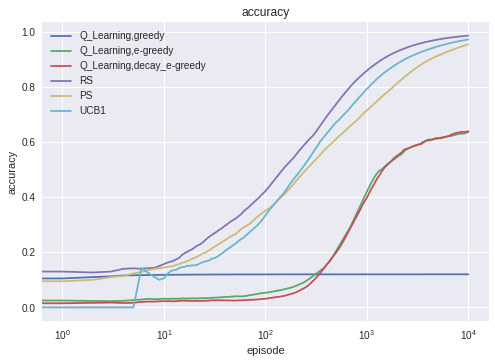

In [25]:
print("『グラフ結果』")
Graph_print.all_graph_print(SIMULATION,all_policy_sumreward,NAME,"accuracy","episode","accuracy")

Accuracyとは全シミュレーションを通してそのエピソードでどれだけ最も当たり確率の高い腕を選択できたかの指標である。
グラフの結果からUCB1よりRSは高いAccuracyを達成できていることが分かる。

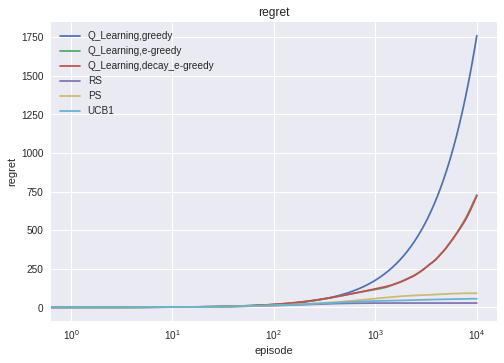

In [26]:
Graph_print.all_graph_print(SIMULATION,all_policy_regret,NAME,"regret","episode","regret")

Regretとはそのエピソードまでで全て最も高い選択をし続けた場合の累積報酬と、そのエピソードまでで実際に選択をして得られた場合の累積報酬の差である。そのため少なければ少ないほどよい。<br>
結果を見るとQ学習系のRegretが高くなっていることが分かる。これはεによって間違った選択をしてしまうためであると推測される。<br>
また、RS方策が最もRegretが低いことがよく分かる。